<a href="https://colab.research.google.com/github/KwameSegbe/TimeSeries-TunnelTraffic/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot


In [ ]:
from numpy.random import seed
seed(2)
import tensorflow as tf
tf.random.set_seed(2)

In [ ]:

## import data
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])
n_future = 7

<AxesSubplot:>

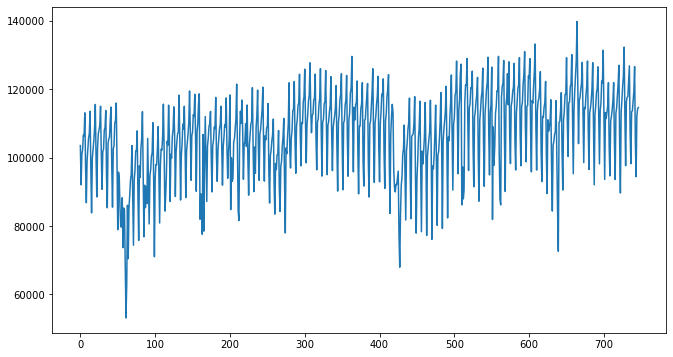

In [ ]:
tunnel.NumVehicles.plot.line(figsize=(11,6))

# AutoARIMA

In [ ]:
ts =  pd.read_csv("tunnel.csv")
ts.set_index('Day', inplace=True)
size = int(len(ts)-n_future)

train = ts.iloc[:size, :].values
test = ts.iloc[size:, :].values

In [ ]:
# from pmdarima.arima import auto_arima

# arima_model = auto_arima(train, start_p=1, start_q=1, d=1, max_p=8, max_q=4, start_P=1,
#                          D=None, start_Q=1, max_P=4, max_D=1, max_Q=4, max_order=5, m=1,
#                          seasonal=True, stationary=False, information_criterion='aic',
#                          alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True,
#                          n_jobs=1, start_params=None, trend=None, method='lbfgs',
#                          maxiter=50, offset_test_args=None, seasonal_test_args=None,
#                          suppress_warnings=True, error_action='trace', trace=False,
#                          random=False, random_state=None, n_fits=10,
#                          return_valid_fits=False, out_of_sample_size=0,
#                          scoring='mse', scoring_args=None, with_intercept='auto',
#                          sarimax_kwargs=None)

# arima_model.summary()

# ARIMA

In [ ]:
t = tunnel.reset_index()
t = t['NumVehicles']
n = len(t)-1
z = np.arange(n)
for i in range(1, n+1):
    z[i-1] = t[i]-t[i-1]

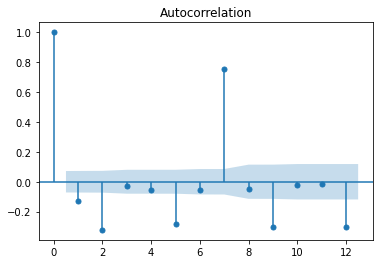

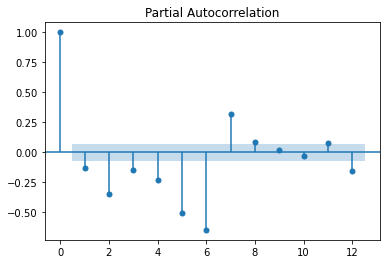

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_ = plot_acf(z, lags=12)
_ = plot_pacf(z, lags=12)

In [ ]:
from sklearn.metrics import mean_squared_error
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    try:
        model = ARIMA(history, order=(7,1,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    except (ValueError, LinAlgError):
        pass
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = mean_squared_error(test, predictions)**0.5
print('Test MSE: %.3f' % rmse)

Test MSE: 4030.644


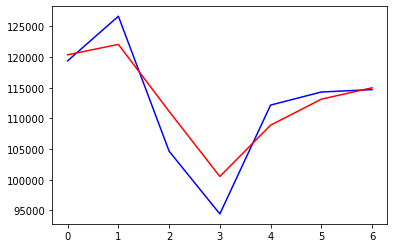

In [ ]:
pyplot.plot(test, color = 'blue', label='test')
pyplot.plot(predictions, color='red', label='pred')
pyplot.show()

# Prophet

In [ ]:
ts = tunnel.reset_index()
ts.rename(columns={'Day':'ds', 'NumVehicles':'y'}, inplace=True)

df_train = ts.iloc[:size]
df_predict = ts['ds'].to_frame()

In [ ]:
from fbprophet import Prophet
model = Prophet()
model.fit(df_train)
predictions = model.predict(df_predict[size:])

error = mean_squared_error(test, predictions.yhat)
rmse = mean_squared_error(test, predictions.yhat)**0.5
print('Test MSE: %.3f' % rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test MSE: 2383.947


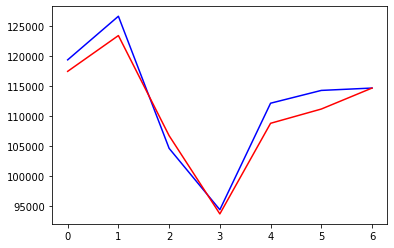

In [ ]:
pyplot.plot(test, color = 'blue', label='test')
pyplot.plot(predictions.yhat, color='red', label='pred')
pyplot.show()

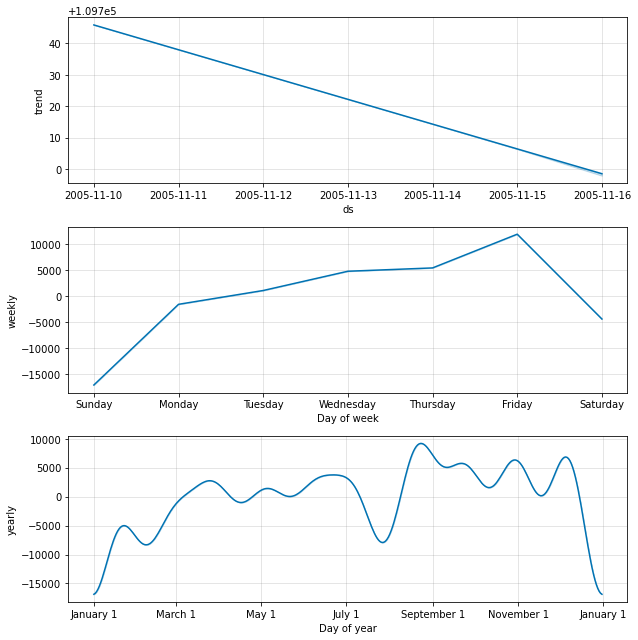

In [ ]:
fig2 = model.plot_components(predictions)

# LSTN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
tunnel = tunnel.set_index("Day").to_period()
df_for_training = tunnel[['NumVehicles']].astype(float)
scaler = StandardScaler()
scaler = scaler.fit(tunnel)
df_for_training_scaled = scaler.transform(tunnel)

In [ ]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future+1):
    trainX.append(df_for_training_scaled[i - n_past:i])
    trainY.append(df_for_training_scaled[i:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (727, 14, 1).
trainY shape == (727, 7, 1).


In [ ]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 128)           66560     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 87,399
Trainable params: 87,399
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
42/42 [==============================] - 2s 17ms/step - loss: 0.9415 - val_loss: 0.9157
Epoch 2/50
42/42 [==============================] - 0s 10ms/step - loss: 0.8636 - val_loss: 0.8242
Epoch 3/50
42/42 [==============================] - 0s 9ms/step - loss: 0.8429 - val_loss: 0.7868
Epoch 4/50
42/42 [==============================] - 0s 10ms/step - loss: 0.8191 - val_loss: 0.7563
Epoch 5/50
42/42 [==============================] - 1s 14ms/step - loss: 0.8070 - val_loss: 0.7338
Epoch 6/50
42/42 [==============================] - 0s 10ms/step - loss: 0.7801 - val_loss: 0.7818
Epoch 7/50
42/42 [==============================] - 1s 12ms/step - loss: 0.7787 - val_loss: 0.6999
Epoch 8/50
42/42 [==============================] - 0s 10ms/step - loss: 0.7450 - val_loss: 0.7197
Epoch 9/50
42/42 [==============================] - 1s 16ms/step - loss: 0.7026 - val_loss: 0.6508
Epoch 10/50
42/42 [==============================] - 1s 12ms/step - loss: 0.6822 - val_loss: 0.5036
Epoch 11/5

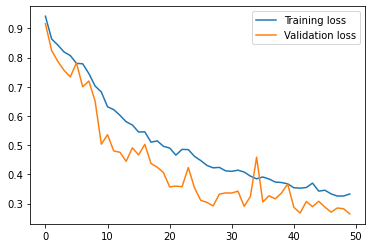

In [ ]:
# fit the model
history = model.fit(trainX[:-n_future,:], trainY[:-n_future,:], epochs=50, batch_size=14, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [ ]:
#predict_period_dates = pd.date_range(list(train_dates)[0], periods=len(train_dates))
train_dates = tunnel.index.to_timestamp()
prediction = model.predict(trainX)
y_pred_future = scaler.inverse_transform(prediction)[-1]

error = mean_squared_error(test,y_pred_future)
rmse = mean_squared_error(test, y_pred_future)**0.5
print('Test MSE: %.3f' % rmse)

Test MSE: 2169.473


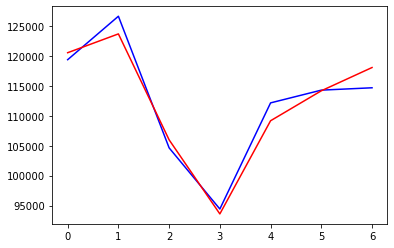

In [ ]:
pyplot.plot(test, color = 'blue', label='test')
pyplot.plot(y_pred_future, color='red', label='pred')
pyplot.show()